### Script for reading data for Problem 5.2 (data_BohrHypothesis.txt) in Applied Statistics 2021 exam:

This script reads the file __"data_BohrHypothesis.txt"__ for Problem 5.2 in the exam of Applied Statistics 2021/22. This data files contains 216545 entries in two columns: 

* **wavelength** (nm) of radiation,
* **voltage** (V) of power supply.

The script was distributed along with the exam and the data file itself on the 20th of January 2022.

####  Author: 
- Troels Petersen (Niels Bohr Institute, petersen@nbi.dk)

####  Date:   
 - 19th of January 2022 (first version)

In [1]:
import scipy
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy import stats
from scipy.stats import binom, poisson, norm           # Functions from SciPy Stats...
# import scipy.optimize as optimization
from scipy import optimize
from numpy.linalg import inv
from functools import partial
from fitter import Fitter
from astropy.modeling import models, fitting
from scipy.optimize import leastsq
import math

In [2]:
import pandas as pd

In [3]:
sys.path.append('D:\my github\Siyi Applied Stats\Documents for JN\AppStat2021-main\External_Functions\\')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

plt.rcParams['font.size'] = 18     # Set some basic plotting parameters

In [4]:
dataframe = pd.read_csv('data_BohrHypothesis.csv', header=0, index_col=None)
wavel, voltage = dataframe.values.T
dataframe

,wavelength(nm),voltage(V)
0,2439.703,134.833
1,1276.206,102.063
2,1665.593,98.818
3,1868.467,123.123
4,2075.338,103.849
...,...,...
216540,1761.204,137.935
216541,1748.524,153.508
216542,1555.461,76.994
216543,1367.070,87.436


Print the first 10 entries to check the content of the file:

In [5]:
for i in range(10):
    print(f"  wavelength = {wavel[i]:4.2f} nm    voltage = {voltage[i]:6.2f} V")

  wavelength = 2439.70 nm    voltage = 134.83 V
  wavelength = 1276.21 nm    voltage = 102.06 V
  wavelength = 1665.59 nm    voltage =  98.82 V
  wavelength = 1868.47 nm    voltage = 123.12 V
  wavelength = 2075.34 nm    voltage = 103.85 V
  wavelength = 1962.51 nm    voltage =  96.54 V
  wavelength = 1563.69 nm    voltage =  91.83 V
  wavelength = 1395.86 nm    voltage = 107.95 V
  wavelength = 2112.96 nm    voltage =  74.54 V
  wavelength = 1434.76 nm    voltage = 129.24 V


In [6]:
print(np.min(wavel),np.max(wavel))

1193.615 5903.585


In [7]:
Nbins = 100
x_all=wavel
xmin,xmax=2100,2200
binwidth = (xmax-xmin)/Nbins  #binwidth = (xmax-xmin)/Nbins
print(binwidth)

condition = (wavel<xmax)*(wavel>xmin)
x_all = wavel[condition]  # x_2是本图xmin, xmax = 2.5, 3.5范围内voltage点,x是将x_2 binned后的
print(np.size(x_all))
print(type(x_all))

xmin_p,xmax_p=1860,1865
condition_p = (wavel<xmax_p)*(wavel>xmin_p)
x_peak = wavel[condition_p]  # x_2是本图xmin, xmax = 2.5, 3.5范围内voltage点,x是将x_2 binned后的
print(np.size(x_peak))
Npeak=np.size(x_peak)
Nbkg=np.size(x_all)-np.size(x_peak)


counts, bin_edges = np.histogram(x_all, bins=Nbins, range=(xmin, xmax))
x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
y = counts[counts>0]
sy = np.sqrt(counts[counts>0])   # NOTE: We (naturally) assume that the bin count is Poisson distributed.
                       # This is an approximation, since there is a low count in the last bins.

# print(np.where(y==177))
print(np.size(x),np.size(y),np.size(sy))

1.0
13359
<class 'numpy.ndarray'>
3312
100 100 100


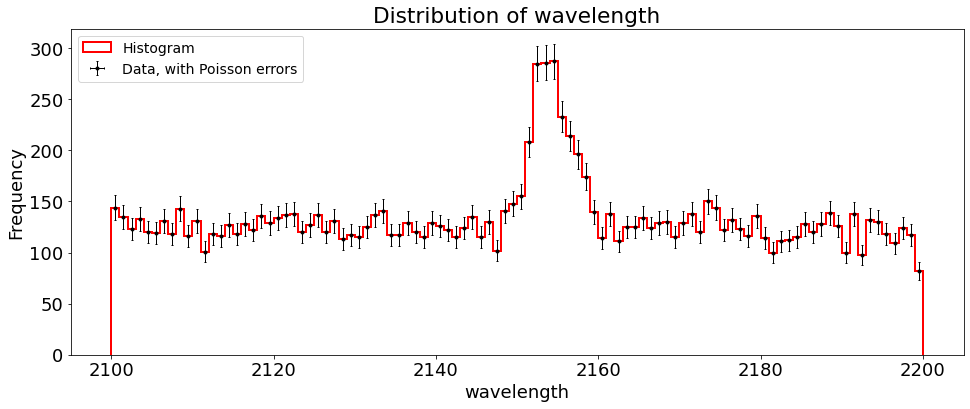

In [8]:
# Create just a single figure and axes, and a (classic) histogram:
fig, ax = plt.subplots(figsize=(16, 6))  # figsize is in inches
#ax.set_yscale('log',nonposy='mask',subsy=[0]) # y-axis log
hist = ax.hist(x_all, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2,color='red', label='Histogram')
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="wavelength",           # the label of the y axis
       ylabel="Frequency",           # the label of the y axis
       title="Distribution of wavelength")    # the title of the plot
ax.legend(loc='upper left', fontsize=14);       # could also be # loc = 'upper right' e.g.


#fig.savefig('fig1',dpi=600)

In [9]:
'''
# Define your actual fitting function, with both background and signal in:
# which is NOT normalised but has normalisation constants "N" in, and includes the bin width:
def fit_pdf(x, Nexp, tau, Ngauss, mu, sigma) :
    """Exponential + Gaussian"""
    return Nexp * binwidth * (1.0 / tau * np.exp(-x/tau))+ Ngauss * binwidth * (1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2))  
'''

'\n# Define your actual fitting function, with both background and signal in:\n# which is NOT normalised but has normalisation constants "N" in, and includes the bin width:\ndef fit_pdf(x, Nexp, tau, Ngauss, mu, sigma) :\n    """Exponential + Gaussian"""\n    return Nexp * binwidth * (1.0 / tau * np.exp(-x/tau))+ Ngauss * binwidth * (1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2))  \n'

In [10]:
def fit_pdf(x,a, Ngauss, mu, sigma) :
    """Exponential + Gaussian"""
    return a + Ngauss * binwidth * (1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2))  

In [11]:
Minuit.print_level = 1    # Print result of fits (generally - can also be moved down to each fit instance)

# Defining Chi2 calculation:
def chi2_owncalc(a, Ngauss, mu, sigma) :
    y_fit = fit_pdf(x,a, Ngauss, mu, sigma)
    chi2 = np.sum(((y - y_fit) / sy)**2)
    return chi2

# Alternatively, use the Chi2 regression from External Functions:
chi2fit = Chi2Regression(fit_pdf, x, y, sy)

minuit_chi2 = Minuit(chi2_owncalc,Ngauss=Npeak, mu=2157, sigma=5,a=100) 
minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
minuit_chi2.migrad()           # This is where the minimisation is carried out! Put ";" at the end to void output

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 119.9                      │              Nfcn = 163              │
│ EDM = 3.87e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a      │   122.7   │    1.2    │            │            │         │         │       │
│ 1 │ Ngauss │    970    │    50     │            │            │         │         │       │
│ 2 │ mu     │ 2.15413e3 │ 0.00015e3 │            │            │         │         │       │
│ 3 │ sigma  │   2.38    │   0.14    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────┐
│        │        a   Ngauss       mu    sigma │
├────────┼─────────────────────────────────────┤
│      a │     1.41    -18.3 -0.00664  -0.0334 │
│ Ngauss │    -18.3 2.81e+03    0.663     3.34 │
│     mu │ -0.00664    0.663   0.0216  0.00453 │
│  sigma │  -0.0334     3.34  0.00453   0.0194 │
└────────┴─────────────────────────────────────┘

In [12]:
# First, check if the result was a valid minimum:
if (not minuit_chi2.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")    
    
# Short hand way of accessing the fit parameters:
fit_Ngauss, fit_mu, fit_sigma, fit_a = minuit_chi2.values[:]   # The fitted values of the parameters

# Loop to get both parameter values and uncertainties:
for name in minuit_chi2.parameters :
    value, error = minuit_chi2.values[name], minuit_chi2.errors[name]
    print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

# Get Chi2 value:
chi2_value = minuit_chi2.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

# Get number of degrees-of-freedom (Ndof):
N_NotEmptyBin = np.sum(y > 0)
Ndof_value = N_NotEmptyBin - minuit_chi2.nfit

Prob_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value:5.10f}")

Fit value: a = 122.65777 +/- 1.18738
Fit value: Ngauss = 973.22080 +/- 52.96949
Fit value: mu = 2154.12636 +/- 0.14695
Fit value: sigma = 2.37977 +/- 0.13941
Chi2 value: 119.9   Ndof = 96    Prob(Chi2,Ndof) = 0.0496385900


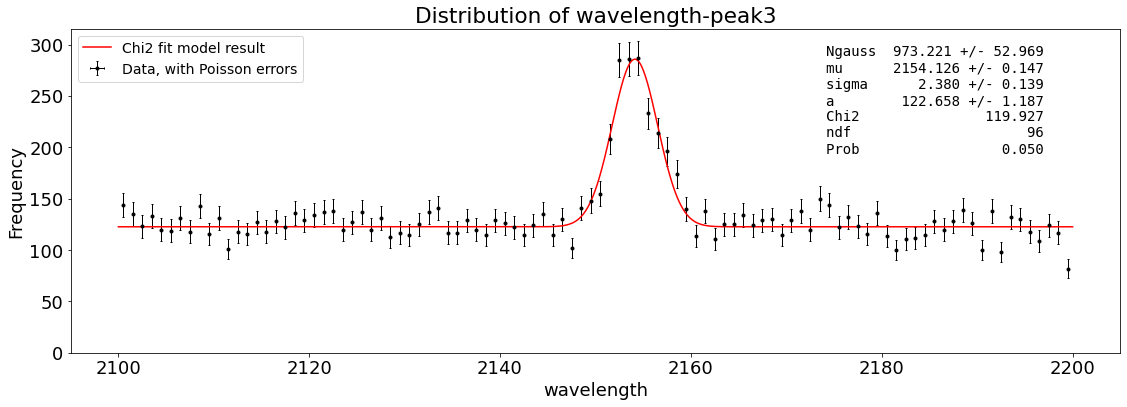

In [14]:

# Create just a single figure and axes, along with a histogram with uncertainties:
fig, ax = plt.subplots(figsize=(16, 6))  # figsize is in inches
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="wavelength", # the label of the y axis
       ylabel="Frequency",  # the label of the y axis
       title="Distribution of wavelength-peak3", # the title of the plot
       ylim=[0.0,None]) # Setting the miminum to zero

# Adding fit function to plot:
x_axis = np.linspace(xmin,xmax, 1000)
ax.plot(x_axis, fit_pdf(x_axis, *minuit_chi2.values[:]), '-r', label='Chi2 fit model result') 

# Adding fit results to plot:
d = {'Ngauss':   [minuit_chi2.values['Ngauss'], minuit_chi2.errors['Ngauss']],
     'mu':       [minuit_chi2.values['mu'], minuit_chi2.errors['mu']],
     'sigma':    [minuit_chi2.values['sigma'], minuit_chi2.errors['sigma']],
     'a':    [minuit_chi2.values['a'], minuit_chi2.errors['a']],
     'Chi2':     chi2_value,
     'ndf':      Ndof_value,
     'Prob':     Prob_value,
    }


#"%e" %
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.72, 0.95, text, ax, fontsize=14)
ax.legend(loc='upper left', fontsize=14); # could also be # loc = 'upper right' e.g.
fig.tight_layout()
fig.savefig('fig7_5',dpi=600)